# Week 3 Day 2 

## Spatial Regression

Now that we know how to run linear regressions, let's go into spatial regressions. 

In [15]:
from pysal.lib import weights
import esda
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn
import contextily as ctx

import params
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

In [28]:
import os
path = os.getcwd()

In [29]:
## Bring in the same data sets from yesterday 

cali = pd.read_excel(path + '/cali.xlsx')
zip = gpd.read_file(path + '/ZipCodes.zip')
risk = pd.read_excel(path + '/Wildfire_2021.xlsx', sheet_name = '2021HO')
insurance = pd.read_excel(path + '/insurance.xlsx')

In [30]:
zip['ZIP_CODE'] = zip['ZIP_CODE'].astype(int)
cali = cali[['ZIP', 'Education', 'Poverty', 'Unemployment',  'Housing Burden', 'Linguistic Isolation', 'Ozone', 'PM2.5']]
cali= cali.groupby(by ='ZIP').mean()
zip_cali = zip.merge(cali, left_on = 'ZIP_CODE', right_on = 'ZIP')


risk = risk[['ZIP Code', 'Avg Fire Risk Score', 'Number of Negligible Fire Risk Exposure',
       'Number of Low Fire Risk Exposure',
       'Number of Moderate Fire Risk Exposure',
       'Number of High Fire Risk Exposure',
       'Number of Very High Fire Risk Exposure', 'Earned Premium']]
calirisk = zip_cali.merge(risk, left_on = 'ZIP_CODE', right_on = 'ZIP Code')

insurance = insurance[insurance['Year']==2020]
df_f = pd.merge(calirisk, insurance, left_on = 'ZIP Code', right_on = 'ZIP Code')

In [31]:
df = gpd.GeoDataFrame(
    df_f, 
    geometry = 'geometry',
    crs = "EPSG:3857")

In [32]:
df['urban'] = 1*(df['POP_SQMI']>1000)
df[['urban']]

,urban
0,1
1,1
2,1
3,1
4,1
...,...
1334,0
1335,0
1336,0
1337,0


### Brief Review of Linear Regressions

In [33]:
## let's rename some variables again 

df= df.rename(columns = {
    'Number of Very High Fire Risk Exposure': 'Very_High', 
    'Avg Fire Risk Score': 'Avg_Risk',
    'Earned Premium': 'Earned_Prem',
    'Housing Burden': 'Hous_Burd',
    'Insurer-Initiated Nonrenewed' : 'Insurer_Nonrenewed',
    'Insured-Initiated Nonrenewed': 'Insured_Nonrenewed',
    'PM2.5' : 'PM25',
    'Linguistic Isolation': 'Ling_Iso'
})

In [34]:
df.shape

(1339, 29)

In [36]:
df= df.dropna()

In [37]:
df.shape

(1282, 29)

In [38]:
## type a multivariate regression like the one we learned yesterday 

mvr = smf.ols(formula = 'Insurer_Nonrenewed ~ Avg_Risk + POP_SQMI + Hous_Burd + Education + Poverty', 
              data =df).fit()

mvr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Insurer_Nonrenewed   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     8.061
Date:                Tue, 18 Jun 2024   Prob (F-statistic):           1.69e-07
Time:                        09:53:35   Log-Likelihood:                -8052.0
No. Observations:                1282   AIC:                         1.612e+04
Df Residuals:                    1276   BIC:                         1.615e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    125.0501     13.649      9.162      0.000      98.272     151.828
Avg_Risk      17.4425      6.400      2.725      0.007       4.886      29.998
POP_SQMI      -0.0032      0.001     -4.609      0.000      -0.005      -0.002
Hous_Burd      2.1375      0.868      2.464      0.014       0.435       3.840
Education      1.4960      0.497      3.008      0.003       0.520       2.472
Poverty       -1.5465      0.449     -3.444      0.001      -2.428      -0.665
==============================================================================
Omnibus:                      713.402   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6844.460
Skew:                           2.424   Prob(JB):                         0.00
Kurtosis:                      13.229   Cond. No.                     2.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Other Ways to Run Linear Regressions

In [39]:
df.columns

Index(['ZIP_CODE', 'PO_NAME', 'STATE', 'POPULATION', 'POP_SQMI', 'SQMI',
       'geometry', 'Education', 'Poverty', 'Unemployment', 'Hous_Burd',
       'Ling_Iso', 'Ozone', 'PM25', 'ZIP Code', 'Avg_Risk',
       'Number of Negligible Fire Risk Exposure',
       'Number of Low Fire Risk Exposure',
       'Number of Moderate Fire Risk Exposure',
       'Number of High Fire Risk Exposure', 'Very_High', 'Earned_Prem',
       'County', 'Year', 'New', 'Renewed', 'Insured_Nonrenewed',
       'Insurer_Nonrenewed', 'urban'],
      dtype='object')

In [57]:
var_main = ['Avg_Risk', 'POP_SQMI', 'Hous_Burd']
var_con = ["Avg_Risk", "POP_SQMI", "Hous_Burd", "Education", "Poverty", "Unemployment"]
var_extend =["Avg_Risk", "POP_SQMI", "Hous_Burd", "Education", "Poverty", "Unemployment", 'Ling_Iso', 'Ozone', 'PM25']

var_dep = ['Insurer_Nonrenewed']

## create your own varialbe list so that you can use it through out the class exercises 
## include 6 variables in the list: 3 main variables of interest and 3 controls 
var_dep_me = ['Poverty']
var_ind_me = ['Avg_Risk', 'Ozone', 'PM25', 'Education', 'Unemployment', 'Ling_Iso'] 

In [49]:
## other ways to run regressions?
from pysal.model import spreg

#Basic regression with only the main independent variables
ols_main = spreg.OLS(
    #Dependent Variable:
    df[var_dep].values,
    #Independent Variable:
    df[var_main].values,
    #Dependent Variable Names
    name_y = 'CRP3850',
    #Independent Variable Names
    name_x = var_main,
    #specify robust standard errors
    robust = 'white',
)

In [50]:
print(ols_main.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     CRP3850                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :           4
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1278
R-squared           :      0.0213
Adjusted R-squared  :      0.0190
Sum squared residual: 2.16289e+07                F-statistic           :      9.2527
Sigma-square        :   16924.042                Prob(F-statistic)     :   4.689e-06
S.E. of regression  :     130.092                Log likelihood        :   -8058.166
Sigma-square ML     :   16871.236                Akaike info criterion :   16124.333
S.E of regression ML:    129.8893                Schwarz criterion     :   16144.958

White Standard Errors
--------------------------------------

In [58]:
## What if we wanted to run the extended list of independent variables?

#Basic regression with only the main independent variables
ols_ext = spreg.OLS(
    #Dependent Variable:
    df[var_dep].values,
    #Independent Variable:
    df[var_extend].values,
    #Dependent Variable Names
    name_y ='Insurer Initiated Nonrenewals',
    #Independent Variable Names
    name_x = var_extend,
    #specify robust standard errors
    
    name_ds = 'OLS Extended Version'
)

In [54]:
print(ols_ext.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :OLS Extended Version
Weights matrix      :        None
Dependent Variable  :Insurer Initiated Nonrenewals                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :          10
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1272
R-squared           :      0.1452
Adjusted R-squared  :      0.1391
Sum squared residual: 1.88909e+07                F-statistic           :     23.9991
Sigma-square        :   14851.356                Prob(F-statistic)     :   3.252e-38
S.E. of regression  :     121.866                Log likelihood        :   -7971.407
Sigma-square ML     :   14735.511                Akaike info criterion :   15962.814
S.E of regression ML:    121.3899                Schwarz criterion     :   16014.376

-----------------------------------

In [59]:
## 'spreg' package has a slightly different code to figure out the r-squared

ols_ext.r2

0.14515682798816976

In [60]:
## the 'spreg' function from pysal allows us to get the results of the error term very easily. 
## let's save the residuals in a separate column in the data frame

df['resid_ols']= ols_ext.u
df[['resid_ols']]

,resid_ols
0,151.760646
1,107.933263
2,144.346884
3,37.696480
4,-0.837254
...,...
1330,-181.916152
1331,11.402626
1335,-40.135441
1337,872.556452


In [ ]:
## Try running a regressoin with the variable list that you created 



In [61]:
df.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

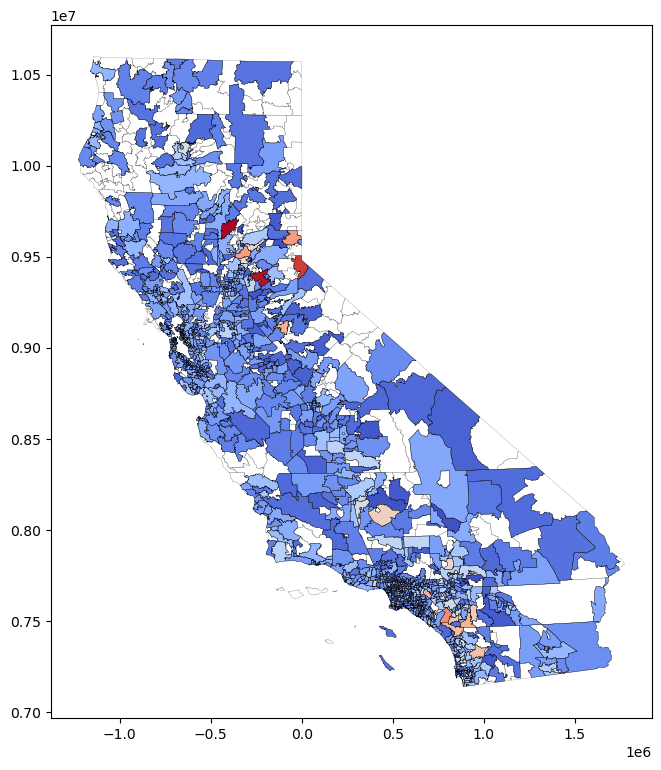

In [62]:
## what happens when we plot the residual results onto a map

fig = plt.figure(figsize=(16,9))
ax=plt.subplot()

df.plot(
    column = 'resid_ols',
    cmap = 'coolwarm',
    edgecolor = 'k',
    linewidth = 0.2,
    ax=ax
)

zip.plot(
    ax=ax,
    alpha = 0.5,
    color = 'none',
    edgecolor = 'k',
    linewidth = 0.2
)

In [63]:
## let's create some weights 

w6 = weights.KNN.from_dataframe(df, k=6)
w6.transform = "R"
w8 = weights.KNN.from_dataframe(df, k=8)
w8.transform = "R"

Text(0, 0.5, 'Spatial Lag OLS Residuals - $Wu$')

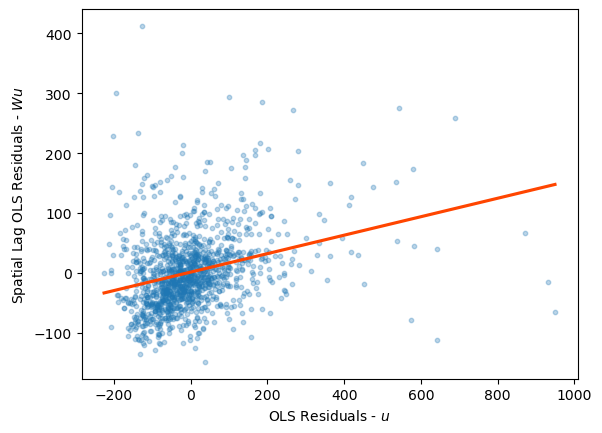

In [65]:
## what if we were to lag the residuals to see any patterns of clustering among the error terms 

resid_lag = weights.spatial_lag.lag_spatial(w6, df['resid_ols'])

ax = seaborn.regplot(
    x= ols_ext.u.flatten(),
    y = resid_lag.flatten(),
    line_kws = dict(color = "orangered"),
    scatter_kws={'alpha' : 0.3, 's' : 10},
    ci = None,
)

ax.set_xlabel('OLS Residuals - $u$')
ax.set_ylabel('Spatial Lag OLS Residuals - $Wu$')

In [67]:
## let's look at the Moran's I value and the p-value 

moran_ols_resid = esda.moran.Moran(df['resid_ols'], w6)

print(moran_ols_resid.I)

print(moran_ols_resid.p_sim)


0.1540993406812452
0.001


In [69]:
## create the lisa variables for Insurer_Nonrenewed and the residuals
lisa_ins = esda.moran.Moran_Local(df['Insurer_Nonrenewed'], w6)
lisa_res = esda.moran.Moran_Local(df['resid_ols'], w6)

Text(0.5, 1.0, 'LISA Map for OLS Residuals')

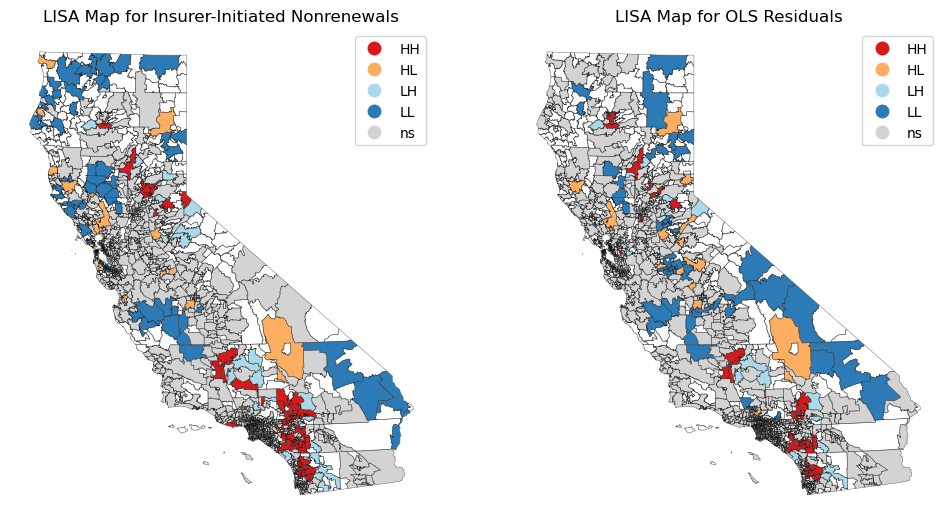

In [70]:
## plot the LISA map 
from splot import esda as esdaplot

fig, ax = plt.subplots(1, 2, figsize=(12,12,))

## first plotting the Insurer Nonrenewed
esdaplot.lisa_cluster(lisa_ins, df, p=0.05, ax=ax[0])
zip.plot(alpha =0.5, color = 'none', edgecolor = 'k', linewidth = 0.4, ax=ax[0])

## next, plotting the residuals 
esdaplot.lisa_cluster(lisa_res, df, p=0.05, ax=ax[1])
zip.plot(alpha =0.5, color = 'none', edgecolor = 'k', linewidth = 0.4, ax=ax[1])

## naming the maps 
ax[0].set_title('LISA Map for Insurer-Initiated Nonrenewals')
ax[1].set_title('LISA Map for OLS Residuals')



A low Moran's I value among the residual terms would indicate that a lot of the variance within the regression is captured by the explanatory variables. If we included all the necessary variables, but still see a high Moran's I in the residuals, that would indicate that there are other phenomena going on that are affecting the dependent variable. In spatial analysis, we suggest that high Moran's I implies spatial patterns that are not captured by the linear regression 

## Diagnostics for Spatial Regressions

In [93]:
ols_ext_sp = spreg.OLS(
    #Dependent Variable:
    df[var_dep].values,
    #Independent Variable:
    df[var_extend].values,
    #Dependent Variable Names
    name_y = 'Insurance',
    #Independent Variable Names
    name_x = var_extend,
    #specify robust standard errors

    #specify weights
    w = w6,
    #print out spatial diagnostics
    spat_diag = True 
)

In [94]:
print(ols_ext_sp.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   Insurance                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :          10
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1272
R-squared           :      0.1452
Adjusted R-squared  :      0.1391
Sum squared residual: 1.88909e+07                F-statistic           :     23.9991
Sigma-square        :   14851.356                Prob(F-statistic)     :   3.252e-38
S.E. of regression  :     121.866                Log likelihood        :   -7971.407
Sigma-square ML     :   14735.511                Akaike info criterion :   15962.814
S.E of regression ML:    121.3899                Schwarz criterion     :   16014.376

------------------------------------------------------------

Based on the diagnostics test that we saw as below, what can we say about the model of best fit?
</figure>
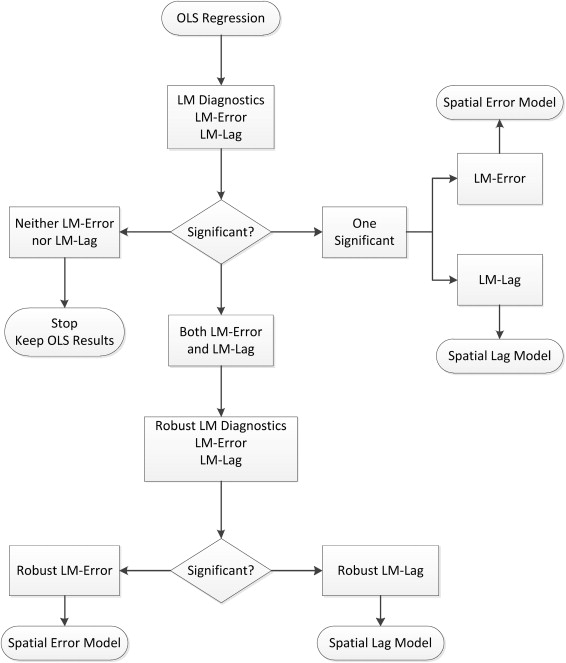

### Spatial Fixed Effects
Just like in the case where we would run linear fixed effect regressions, we could also do that spatially. The spatial fixed effect is particularly useful when we have a linear regression with a categorical variable. 
Fixed effects allows us to account for different neighborhoods/ regions/ spatial clusters, and basically run different regressions for each geographic area.
By holding all other variables constant, the spatial fixed effect allows for greater degrees of isolation. In otherwords, instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern that affect its behavior. 


In [ ]:
sfe = spreg.OLS_Regimes(
    #Dependent Variable

    # Independent Variable

    # Variable specifying neighborhood membership

    # Allow constant term to vary by group/regime 

    # Variables to be allowed to vary (True), or kept constant (False)

    # Allow separate sigma coefficients to be estimated by regime

    # Dependent Variable Name\

    # Independent variable names

)

In [ ]:
print(sfe.summary)

### SLX Model - Spatially Lagged X Model - Spatially Lagged Exogenous Variable


$$
(InsurerNonrenewals_i) = \alpha + \mathbf{X}\beta + \mathbf{WX}\gamma + \epsilon
$$

This is basically adding lagged X variables into the regression

In [ ]:
df.head()

In [79]:
## make a loop to create spatially weighted varaibles 

var_lag = df[var_extend].apply(lambda w: weights.spatial_lag.lag_spatial(w6, w))
var_lag = var_lag.rename(columns = lambda c : 'W_' + c)
                               

In [80]:
var_lag

,W_Avg_Risk,W_POP_SQMI,W_Hous_Burd,W_Education,W_Poverty,W_Unemployment,W_Ling_Iso,W_Ozone,W_PM25
0,0.360000,17073.963333,33.711179,50.791270,58.842297,9.114989,19.848989,0.044920,12.101055
1,0.350000,15427.873333,33.826709,43.614119,57.518511,8.197222,14.288861,0.043684,12.099204
2,0.361667,16602.541667,34.134580,41.671671,56.321144,8.984458,14.951321,0.044062,12.059613
3,0.506667,27539.786667,27.989744,25.641248,49.037589,6.795690,31.564995,0.048174,12.040226
4,0.485000,29726.140000,27.136058,29.514567,49.268183,5.393537,31.880371,0.047550,12.067725
...,...,...,...,...,...,...,...,...,...
1330,2.601667,34.053333,15.805556,4.901389,24.852222,3.633333,0.602778,0.053522,6.755329
1331,1.888333,8.040000,13.691667,8.500000,31.425000,8.583333,0.975000,0.050120,6.008926
1335,2.483333,44.968333,16.266667,6.241667,25.965000,4.346296,0.928333,0.051768,6.287956
1337,2.613333,67.101667,17.427778,6.243056,27.766111,6.200000,2.225000,0.051430,6.147210


In [78]:
## join the two variable lists together 

var_slx = df[var_extend].join(var_lag)

In [81]:
var_slx

,Avg_Risk,POP_SQMI,Hous_Burd,Education,Poverty,Unemployment,Ling_Iso,Ozone,PM25,W_Avg_Risk,W_POP_SQMI,W_Hous_Burd,W_Education,W_Poverty,W_Unemployment,W_Ling_Iso,W_Ozone,W_PM25
0,0.35,16970.82,34.500000,51.656250,59.625000,8.500000,19.312500,0.044953,12.126347,0.360000,17073.963333,33.711179,50.791270,58.842297,9.114989,19.848989,0.044920,12.101055
1,0.35,17281.61,33.641667,48.858333,63.575000,10.458333,17.625000,0.044129,12.074751,0.350000,15427.873333,33.826709,43.614119,57.518511,8.197222,14.288861,0.043684,12.099204
2,0.34,20503.42,38.150000,48.240000,64.760000,8.850000,16.730000,0.044193,12.110824,0.361667,16602.541667,34.134580,41.671671,56.321144,8.984458,14.951321,0.044062,12.059613
3,0.55,20508.65,26.611765,26.188235,47.382353,4.464706,28.294118,0.047899,12.058694,0.506667,27539.786667,27.989744,25.641248,49.037589,6.795690,31.564995,0.048174,12.040226
4,0.51,26823.08,28.492857,30.671429,54.142857,6.357143,36.614286,0.046937,12.105165,0.485000,29726.140000,27.136058,29.514567,49.268183,5.393537,31.880371,0.047550,12.067725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2.38,1.76,17.400000,7.600000,31.700000,5.300000,0.000000,0.053868,6.421772,2.601667,34.053333,15.805556,4.901389,24.852222,3.633333,0.602778,0.053522,6.755329
1331,1.36,25.69,15.400000,6.025000,37.325000,5.400000,0.300000,0.048278,5.034124,1.888333,8.040000,13.691667,8.500000,31.425000,8.583333,0.975000,0.050120,6.008926
1335,2.42,225.50,22.900000,8.800000,36.400000,1.400000,9.450000,0.049589,5.988902,2.483333,44.968333,16.266667,6.241667,25.965000,4.346296,0.928333,0.051768,6.287956
1337,2.12,151.87,18.400000,9.875000,29.310000,5.844444,3.720000,0.050009,4.245082,2.613333,67.101667,17.427778,6.243056,27.766111,6.200000,2.225000,0.051430,6.147210


In [83]:
## write out the equation for the SLX regression

slx = spreg.OLS(
    # Dependent Variable
    df[var_dep].values,
    # Independent Variable
    var_slx.values,
    # Dependent Variable Name 
    name_y = 'Insurance Nonrenewals',
    # Independent Variable Names
    name_x = var_slx.columns.tolist(),
    name_ds = 'SLX Model'
)

In [84]:
## Betas?
slx.betas


array([[-7.29766708e+01],
       [ 1.82672862e+00],
       [ 7.50951476e-04],
       [ 1.67922302e+00],
       [ 2.16290447e+00],
       [-2.03009212e+00],
       [-1.07389712e+00],
       [-1.78042451e+00],
       [ 3.56357676e+03],
       [ 2.06449534e+01],
       [ 2.65806066e+01],
       [-4.54175828e-04],
       [ 2.44505101e+00],
       [ 3.31552006e+00],
       [-3.04462379e+00],
       [ 7.78908467e+00],
       [-3.88418818e+00],
       [ 9.36122785e+02],
       [-2.32107835e+01]])

In [85]:
## standard errors?
slx.std_err

array([2.62554319e+01, 1.03505183e+01, 9.90720508e-04, 1.03100941e+00,
       7.46178592e-01, 6.66201211e-01, 1.51412621e+00, 9.12664356e-01,
       2.24598469e+03, 6.10145034e+00, 1.41352824e+01, 1.17849262e-03,
       1.59971210e+00, 1.11298413e+00, 9.69340431e-01, 2.77846433e+00,
       1.32753364e+00, 2.28716269e+03, 6.57040173e+00])

In [92]:
slx.t_stat

[(-2.77948848805295, 0.005525212368860017),
 (0.17648668116443827, 0.8599399058340437),
 (0.7579851940261615, 0.44860125056622224),
 (1.628717444424852, 0.10362223324308575),
 (2.8986418217148113, 0.0038125842390789675),
 (-3.0472657333749527, 0.002357270747241438),
 (-0.7092520491892853, 0.47829898155916806),
 (-1.9507987776792695, 0.05130188130187589),
 (1.5866433887703533, 0.11284374482633928),
 (3.3836140995131267, 0.0007373100518658096),
 (1.8804439704505433, 0.060277552343560525),
 (-0.3853870774302932, 0.7000155506890723),
 (1.5284319014693655, 0.12665573153338935),
 (2.9789463859100387, 0.0029476487926261914),
 (-3.140923140390633, 0.0017232605759762544),
 (2.8033776004253825, 0.005134413356335673),
 (-2.9258679779971235, 0.003496380488395072),
 (0.40929435772510436, 0.6823930543627359),
 (-3.5326277534035064, 0.00042628752067444434)]

In [88]:
## summary report?

print(slx.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :   SLX Model
Weights matrix      :        None
Dependent Variable  :Insurance Nonrenewals                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :          19
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1263
R-squared           :      0.1764
Adjusted R-squared  :      0.1647
Sum squared residual: 1.82005e+07                F-statistic           :     15.0284
Sigma-square        :   14410.524                Prob(F-statistic)     :   3.937e-42
S.E. of regression  :     120.044                Log likelihood        :   -7947.541
Sigma-square ML     :   14196.952                Akaike info criterion :   15933.082
S.E of regression ML:    119.1510                Schwarz criterion     :   16031.049

---------------------------------------------------

In [91]:
## can we make that into a data frame?

pd.DataFrame(
    {
        "Coeff" : slx.betas.flatten(),
        "Std. Error" : slx.std_err.flatten(),
        "p-value": [i[1] for i in slx.t_stat],

    },
index= slx.name_x
)

,Coeff,Std. Error,p-value
CONSTANT,-72.976671,26.255432,0.005525
Avg_Risk,1.826729,10.350518,0.859940
POP_SQMI,0.000751,0.000991,0.448601
Hous_Burd,1.679223,1.031009,0.103622
Education,2.162904,0.746179,0.003813
Poverty,-2.030092,0.666201,0.002357
Unemployment,-1.073897,1.514126,0.478299
Ling_Iso,-1.780425,0.912664,0.051302
Ozone,3563.576763,2245.984692,0.112844
PM25,20.644953,6.101450,0.000737


In [ ]:
### with the variables that you are interested in, try creating dataframe for the SLX results 



### SLM (Spatial Lag Model) - Lagged Y variable - Spatially Lagged Endogenous Variable

$$
{InsurerNonrenewals_i} = \alpha + \rho {InsurerNonrenewals_{lag-i}} + \sum_k \beta_k X_{ki} + \epsilon_i
$$

In [96]:
## write the equation for the SLM 

slm = spreg.GM_Lag(
    df[var_dep].values,
    df[var_extend].values,
    w= w6, 
    name_y ='Insurer NR',
    name_x = var_extend,
)

In [97]:
## print out the summary statistic

print(slm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Insurer NR                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :          11
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1271
Pseudo R-squared    :      0.2260
Spatial Pseudo R-squared:  0.1177

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       -20.07831        22.42839        -0.89522         0.37067
            Avg_Risk         0.78454         6.70773         0.11696         0.90689
            POP_SQMI         0.00038      

In [106]:
## what if we wanted to create a dataframe with the information on coeff, std error and p-value?

pd.DataFrame(
    {
    "Coeff.": slm.betas.round(4).flatten(),
    "Std. Error": slm.std_err.round(4).flatten(),
    "p-value": [i[1].round(4) for i in slm.z_stat],
    },
    index = slm.name_z,

)


,Coeff.,Std. Error,p-value
CONSTANT,-20.0783,22.4284,0.3707
Avg_Risk,0.7845,6.7077,0.9069
POP_SQMI,0.0004,0.0007,0.5896
Hous_Burd,0.9679,0.8817,0.2723
Education,1.4904,0.6413,0.0201
Poverty,-1.2285,0.5565,0.0273
Unemployment,-1.3688,1.3644,0.3157
Ling_Iso,-1.5661,0.7484,0.0364
Ozone,1070.5084,753.7729,0.1555
PM25,1.2843,2.0776,0.5365


In [109]:
slm.z_stat

[(-0.8952185471488276, 0.3706702719687063),
 (0.11696028661756182, 0.9068915241106336),
 (0.5393650537495558, 0.5896349892732243),
 (1.0977669023093228, 0.27230628745443264),
 (2.3241617122998885, 0.020116828524103264),
 (-2.207603556076734, 0.027271921041154428),
 (-1.0032304300033794, 0.315749694010241),
 (-2.092586626121512, 0.03638607144683253),
 (1.420200287891708, 0.1555493798791323),
 (0.6181846162256693, 0.5364536495917532),
 (5.090482170808804, 3.571541548053332e-07)]

In [ ]:
## With the list of variables that you are interested in, try creating a SLM model result dataframe



### SEM (Spatial Error Model) - Lagged $u$ variable

$$
{InsurerNonrenewals_i} = \alpha + \sum_k \beta_k X_{ki} + u_i
$$

$$
u_i = \lambda u_{lag-i} + \epsilon_i
$$

where $u_{lag-i} = \sum_j w_{i,j} u_j$. 

In [111]:
## write codes for SEM 

sem = spreg.GM_Error_Het(
    df[var_dep].values,
    df[var_extend].values,
    w=w6,
    name_y = ":)",
    name_x = var_extend
)


In [112]:
## print out the results

print(sem.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :          :)                Number of Observations:        1282
Mean dependent var  :    137.9072                Number of Variables   :          10
S.D. dependent var  :    131.3436                Degrees of Freedom    :        1272
Pseudo R-squared    :      0.1389
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       -57.87686        31.35725        -1.84573         0.06493
            Avg_Risk         5.20831        10.12527    

In [113]:
## what if we wanted to create a dataframe with the information on coeff, std error and p-value?

pd.DataFrame(
    {
    "Coeff.": sem.betas.flatten(),
    "Std. Error": sem.std_err.flatten(),
    "p-value": [i[1] for i in sem.z_stat],
    },
    index = sem.name_x,

).reindex(['lambda']).round(4)


,Coeff.,Std. Error,p-value
lambda,0.4614,0.0498,0.0


### Diagnostics 

In [114]:
## Lower Values for the Bayesian Information Criteria is better 

slx_res = spreg.schwarz(slx)
slm_res = spreg.schwarz(slm)

print( slx_res, slm_res)

16031.049008433947 15903.454176192317


In [115]:
slm_res = spreg.schwarz(sem)

AttributeError: 'GM_Error_Het' object has no attribute 'utu'